In [173]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from matplotlib import pyplot as plt

In [174]:
import pandas as pd

In [175]:
df = pd.read_csv("./train.csv")

In [176]:
df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,league
0,3.0,12.0,0.0,14.0,4.0,0.0,Stuttgart,07/08/09,H,6.0,12.0,0.0,13.0,7.0,0.0,0.0,0.0,Wolfsburg,bundesliga
1,1.0,10.0,0.0,7.0,0.0,1.0,FC Koln,08/08/09,H,16.0,8.0,0.0,24.0,11.0,0.0,0.0,0.0,Dortmund,bundesliga
2,3.0,20.0,0.0,15.0,3.0,2.0,Hannover,08/08/09,H,5.0,16.0,0.0,10.0,4.0,0.0,0.0,3.0,Hertha,bundesliga
3,10.0,28.0,0.0,9.0,3.0,2.0,Bayern Munich,08/08/09,D,3.0,10.0,0.0,9.0,1.0,1.0,1.0,0.0,Hoffenheim,bundesliga
4,5.0,28.0,0.0,13.0,7.0,2.0,Leverkusen,08/08/09,D,3.0,22.0,0.0,8.0,4.0,2.0,1.0,1.0,Mainz,bundesliga


# cleanup the train and test dataset

In [177]:
df_cleaned = df.dropna(axis = 0, how ='any') 

In [178]:
y = df_cleaned.FTR
X= df_cleaned.drop("FTR",axis=1)
X = X.drop("Date",axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [179]:
X["AwayTeamEnc"] = le.fit_transform(X["AwayTeam"].astype(str))
X["HomeTeamEnc"] = le.fit_transform(X["HomeTeam"].astype(str))
X["leagueEnc"] = le.fit_transform(X["league"].astype(str))
X= X.drop("AwayTeam", axis=1)
X=X.drop("HomeTeam", axis=1)
X= X.drop("league", axis=1)

In [180]:


y = le.fit_transform(df_cleaned.FTR)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((9582, 17), (9582,), (3194, 17), (3194,))

# adjust weight for imbalance in dataset

In [181]:
import numpy as np
np.unique(y_train)
len(y_train)
ratio_0 = float(np.sum(y_train == 0)) / len(y_train)
ratio_1 = float(np.sum(y_train == 1)) / len(y_train)
ratio_2 = float(np.sum(y_train == 2)) / len(y_train)

ratio_0, ratio_1, ratio_2, len(y_train)

(0.27896055103318723, 0.25683573366729284, 0.4642037152995199, 9582)

In [182]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 27
weights[y_train == 1] = 25
weights[y_train == 2] = 46

import xgboost as xgb

dtrain = xgb.DMatrix(data=X_train, label=y_train, weight=weights) 
dtest = xgb.DMatrix(data=X_test)

# Train xgboost model

In [210]:
params = {
    'max_depth': 8,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3,
    'n_gpus': 0
}
params['eval_metric']  = ['merror', 'mlogloss']

In [211]:

bst = xgb.train(params, dtrain)

In [185]:
watchlist  = [(dtest,'test'), (dtrain,'train')]
num_rounds = 5

In [186]:
bst2 = xgb.train(params, dtrain, num_rounds)

In [187]:
num_rounds = 10 # how many estimators
seed=123
hist = xgb.cv(params, dtrain, num_rounds, nfold=10, metrics={'merror'}, seed=seed)
hist

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.305340,0.008075,0.307623,0.014733
1,0.305512,0.006312,0.306840,0.021351
2,0.293681,0.002203,0.298005,0.021260
3,0.290468,0.003196,0.295053,0.019335
4,0.287630,0.003522,0.291485,0.020561
5,0.285172,0.003466,0.289555,0.019262
6,0.283052,0.002313,0.289389,0.020894
7,0.282165,0.003178,0.288255,0.021188
8,0.281071,0.002814,0.286847,0.018910
9,0.279849,0.002527,0.286449,0.018540


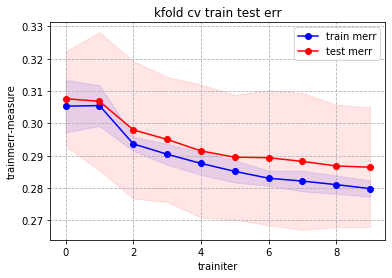

In [188]:
hist["iteration"] = hist.index
train_iter = hist["iteration"]
train_mean = hist["train-merror-mean"]
train_std = hist["train-merror-std"]
test_mean = hist["test-merror-mean"]
test_std = hist["test-merror-std"]
alpha = 0.1
 

plt.plot(train_iter, train_mean, label='train merr', color='blue', marker='o')
plt.fill_between(train_iter, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=alpha)
plt.plot(train_iter, test_mean, label='test merr', color='red', marker='o')

plt.fill_between(train_iter, test_mean + test_std, test_mean - test_std, color='red', alpha=alpha)
plt.title("kfold cv train test err")
plt.xlabel('trainiter')
plt.ylabel('trainmerr-measure')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# Cross validations

In [124]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
# https://datascience.stackexchange.com/questions/29067/how-to-optimize-xgboost-performance-accuracy
xgb_model = xgb.XGBClassifier()
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(X,y)
print(model.best_score_)
print(model.best_params_)

ModuleNotFoundError: No module named 'sklearn.grid_search'

# Metrics

In [212]:
pred = bst.predict(dtest)

In [190]:
pred2 = bst2.predict(dtest)

In [213]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.66      0.65      0.65       891
           D       0.46      0.15      0.23       821
           H       0.65      0.90      0.75      1482

    accuracy                           0.64      3194
   macro avg       0.59      0.57      0.55      3194
weighted avg       0.60      0.64      0.59      3194



In [159]:
print(classification_report(y_test, pred2, target_names=le.classes_))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [101]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [160]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, pred)))


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [161]:
from sklearn.metrics import precision_recall_fscore_support as score



precision, recall, fscore, support = score(y_test, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [105]:
print(bst.attributes)

<bound method Booster.attributes of <xgboost.core.Booster object at 0x7f89ed68b2b0>>


# Identify importance features

<Figure size 2160x3600 with 0 Axes>

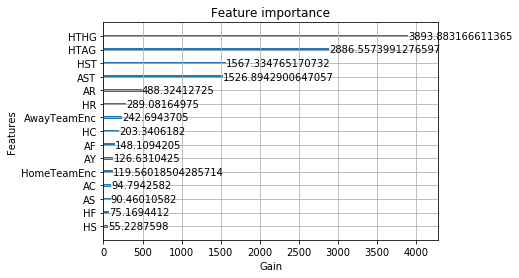

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 50))
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')

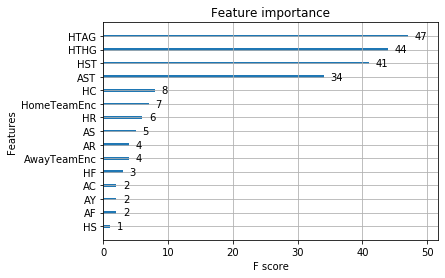

In [91]:
xgb.plot_importance(bst)

In [89]:
importances = bst.get_fscore()
importances

{'HTAG': 47,
 'HTHG': 44,
 'AST': 34,
 'HST': 41,
 'HF': 3,
 'HR': 6,
 'AwayTeamEnc': 4,
 'AS': 5,
 'HomeTeamEnc': 7,
 'HC': 8,
 'HS': 1,
 'AF': 2,
 'AY': 2,
 'AR': 4,
 'AC': 2}

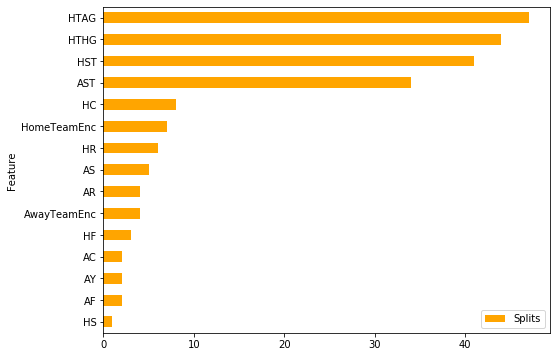

In [90]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange')

# the end